<a href="https://colab.research.google.com/github/WRFitch/fyp/blob/main/src/fyp_ai_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI data analysis

## Notes on Use. 
Because fastai can be a bit silly, restart runtime when you have to. Yes, it's very annoying. 

### Setup
- Install & import necessary libraries

In [ ]:
# Sometimes the colab fastai version can be wrong, so we reinstall with no cache
# uninstalling, reinstalling, and restarting runtime should fix any major issues. 
!pip uninstall -y fastai
!pip install -U --no-cache-dir fastai

In [2]:
# TODO clean up imports - I can't seriously need all this
import numpy as np
import pandas as pd

from fastai import *
from fastai.tabular import *
from fastai.vision import *
from fastai.vision.all import *
from google.colab import drive
import matplotlib.pyplot as plt

In [3]:
drive.mount('/content/drive')

#print(fastai.__version__)

Mounted at /content/drive


In [4]:
drive_path = "/content/drive/MyDrive/"

CO_band = 'CO_column_number_density'
HCHO_band = 'tropospheric_HCHO_column_number_density'
NO2_band = 'tropospheric_NO2_column_number_density'
O3_band = 'O3_column_number_density'
SO2_band = 'SO2_column_number_density'
CH4_band = 'CH4_column_volume_mixing_ratio_dry_air'

In [5]:
# Import data from google drive 
# This is getting really slow. Is there too much data? If so, slice to only use every tenth image so we still get a 
# decently stratified set. 
path = f"{drive_path}img_export"
imgs = get_image_files(f"{path}/png")

In [6]:
len(imgs)

4420

## Parse CSVs into pandas dataframe 

In [7]:
ghg_df = pd.read_csv(f"{path}/{SO2_band}.csv")

## Implement label function 

In [18]:
# Define a label function for image data by getting centroid long and lat from image filename, then accessing the 
# corresponding GHG values from the pandas dataframe defined above. 

# TODO update to include all GHG datasets, including making sure missing values are accounted for. This might be done by
#      removing 
def label_func(path):
  file = str(path)
  # get filename from filepath, remove file extension and split into longitude and latitude. 
  coords = list(map(float, file.split("/")[-1][0:-4].split("_")))
  # we have to round both of the coordinate values to get around floating-point limitations. 
  r_precision=10
  so2 = ghg_df.loc[(round(ghg_df["longitude"], r_precision) == round(coords[0], r_precision)) & \
                   (round(ghg_df["latitude" ], r_precision) == round(coords[1], r_precision))]
  
  # AI is currently confused at the very tiny values of SO2 - for now, multiplying by 10k to get a decent predictor. 
  return so2.at[so2.index[-1],SO2_band] * 10000

In [19]:
label_func(f"{path}/png/0.39975030143318707_51.136597548503765.png")

2.0110000065553777

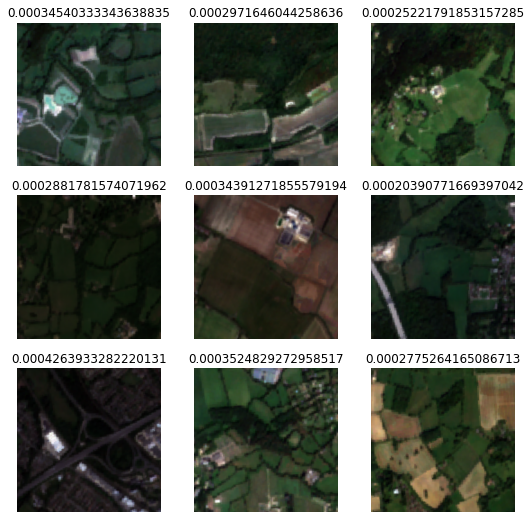

In [10]:
# Define ImageDataLoader
# TODO look into other item_tfms options - what other transforms can be done?
# - 90-degree rotations
# - Slicing and dicing these together (would that work?..)
imgLoader = ImageDataLoaders.from_name_func(path, imgs, label_func, item_tfms=Resize(224))
imgLoader.show_batch()

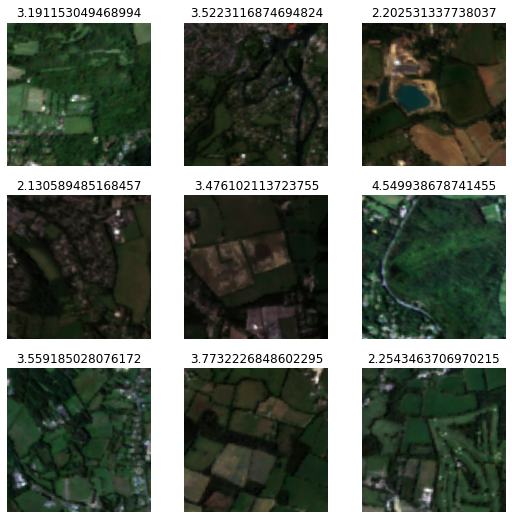

In [90]:
# TODO update transforms - are vertical flips valid? does north-south orientation actually matter? 
#                        - Duplicating the dataset through each horz flip, vert flip and 90 degree rotation would be 
#                          ideal. 
imgBlock = DataBlock(
    blocks = (ImageBlock, RegressionBlock),
    get_items = get_image_files,
    get_y = label_func,
    item_tfms = (Resize(224), 
                 DihedralItem)
)

imgsFromBlock = imgBlock.dataloaders(f"{path}/png")
imgsFromBlock.show_batch()

In [91]:
# Examining imgLoader so I can understand what's going down 
img, so2 = imgsFromBlock.one_batch()
print(img.shape)
print(so2.shape)

(64, 3, 224, 224)
torch.Size([64])


### Training

- Train image-based predictor to guess greenhouse gas concentrations based on 1km square of land. 
  - Transfer an ImageNet predictor to work top-down
  - Start by predicting one ghg and expand from there
- Use image predictor to extract a basic feature set by slicing the network at different points. The idea is to limit the amount of data going into the tabular recommender, while transferring as much useful data as possible. We want to implicitly extract GHG-emitting features of each image without losing any detail, as a form of convolutional preprocessing. 
- pipe this feature extractor into a tabular recommender along with other feature data that may either improve tabular predictions by influencing GHG concentrations, or hint at subtle relationships between prospectively disparate factors:
  - Land prices
  - Prevailing wind direction 
  - Land use 
  - Population density
  - Economic output
  - Land height
  - Biodiversity
  - Atmospheric water vapour. 
  - **NB This is not something to get excessively distracted by - finish the basics before looking for further data** 

In [92]:
# uses a regression approach.
# TODO figure out how y_range works. 
# TODO analyse metrics. Really it doesn't seem to matter so long as everything is evaluated equally, but I'd like to be sure. 
learn = cnn_learner(imgsFromBlock, resnet34, y_range=(1, 5), metrics=(rmse, mse))

In [93]:
name = "learner test"
learn.save(name)

Path('models/learner test.pth')

In [64]:
learn.load(name)

SuggestedLRs(lr_min=9.120108734350651e-06, lr_steep=4.786300905834651e-06)

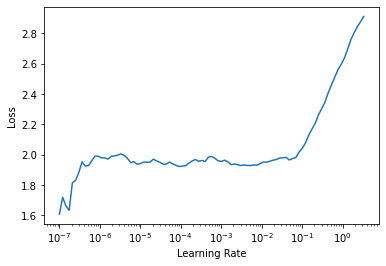

In [94]:
# Experimenting if this changes as we fine-tune the model 
learn.lr_find()

In [ ]:
# TODO figure out how I can improve the detail of train_loss, valid_loss, and accuracy. For now, I'm bumping the results
#      back up over 1. 
learn.fine_tune(5, 0.0009)

epoch,train_loss,valid_loss,_rmse,mse,time
0,1.106976,0.733064,0.856192,0.733064,00:25


epoch,train_loss,valid_loss,_rmse,mse,time


In [88]:
learn.fine_tune(2, 0.000363)

epoch,train_loss,valid_loss,_rmse,mse,time
0,0.708386,0.663134,0.814330,0.663134,00:24


epoch,train_loss,valid_loss,_rmse,mse,time
0,0.671039,0.609585,0.780759,0.609585,00:26
1,0.627050,0.602789,0.776395,0.602789,00:27


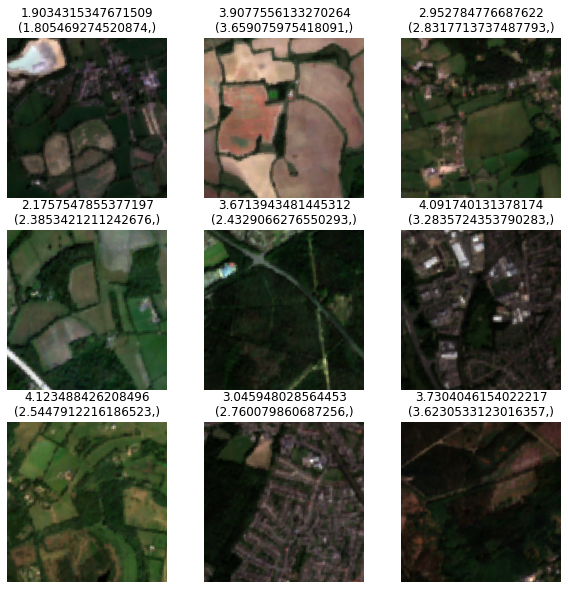

In [89]:
learn.show_results(ds_idx=1, nrows=3, figsize = (10,10))